In [1]:
import pandas as pd
import numpy as np

import torch
from torch.autograd.functional import hessian

from variational_sgd.bayesian_regression import get_mcmc_sample
from variational_sgd.sgd import sgd_sampler

from variational_sgd.tools import lyapunov
from variational_sgd.utils import confidence_ellipse

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

## Read the Data

In [2]:
data = pd.read_csv('./data/winequality-red.csv')
data = (data-data.mean())/data.std()
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910,-0.584594,-0.787576
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074,-0.584594,-0.787576
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036,-0.584594,0.450707
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025,-0.959946,-0.787576


In [3]:
data.cov()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


## Linear Regression bayesian


<p> The goal here is to estimate the parameter *quality*. To do so we are going to make a linear model between the \texit{quality} as a few others explicative variables taken by there value of covariance with the *quality*:

- *volatile acidity*
- *alcohol*
- *citric acid*
- *density*
- *sulphates* </p>

<p> On considère alors le modèle linéaire suivant: $$y \sim \mathcal{N}(\alpha + \beta X , \sigma^2), \mbox{ with } \alpha, \log \sigma \sim \mathcal{N}(0, 1)\mbox{, }\beta \sim \mathcal{N}(0, \mathbf{I})\mbox{, et }\theta=(\alpha, \beta, \log(\sigma))$$ </p>

In [4]:
var = ['volatile acidity', 'alcohol', 'citric acid', 'density', 'sulphates'] # explicative variables
X, y = data[var].values, data['quality'].values
D = 7 # dimension of theta intercept + variance + coefficients

We will now sample the *posterior*. But first as bayesian, we need to define the *prior* $\theta$. Let us assume simply that $\alpha$ and $\log \sigma$ are gaussian with distribution $\mathcal{N}(0,1)$. And suppose that $\beta$ is multivariate such that $\beta \sim \mathcal{N}(0, \mathbb{I}_5)$.

In [5]:
# MCMC
trace = get_mcmc_sample(X, y)

# Historique des tirages
theta = np.column_stack([trace.alpha, trace.log_sigma, trace.beta])

/Users/geoffroy/Desktop/Cours/mva/Bayesian/VASGA/variational_sgd/bayesian_regression.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


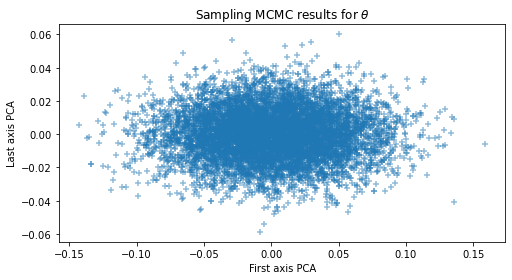

In [6]:
# On affiche le résultat sur les premier et dernier axes principaux
pca = PCA()
pca.fit(theta)
theta_pca = pca.transform(theta)

plt.figure(figsize=(8, 4))
plt.scatter(theta_pca[:, 0], theta_pca[:, -1], alpha=0.5, marker='+')
plt.xlabel('First axis PCA')
plt.ylabel('Last axis PCA')
plt.title(r'Sampling MCMC results for $\theta$')
plt.show()

### The SGD sampler

We recall the value of the loss:
$$\mathcal{L}(\theta) = \frac{1}{N} \sum \limits_{i \in \mathcal{S}} \ell_n(\theta),$$

with $\ell_n(\theta) = - \log p(x_i|\theta) + \frac{1}{N}\log p(\theta)$.

In [7]:
def _loss(θ, x_, y_, N):
    cst = torch.tensor(np.log(2*np.pi), requires_grad=False)
    
    # f1 opposite log of p(x_i|theta) 
    f1 = 0.5*torch.exp(-2*θ[1]) * (θ[0] + torch.dot(θ[2:], x_)  - y_)**2 + θ[1] + 0.5*cst
    
    # f2 correspond to the "regularization"
    f2 = (-1/(2*N))*(θ[0]**2 +  θ[1]**2 + torch.dot(θ[2:], θ[2:]) + θ.shape[0]*cst)
    
    return f1 + f2

def _loss_tot(θ, X, y):
    N = len(y)
    loss = 0
    for k in range(N):
        loss += _loss(θ, X[k], y[k], N)
    return loss / N

Let's now put that into our sgd_sampler.

In [8]:
X_tensor = torch.tensor(X, requires_grad=False, dtype=torch.float64) 
y_tensor = torch.tensor(y, requires_grad=False, dtype=torch.float64)

mini_batch_size = 100
B = 3*np.eye(D)
tr = np.trace(B@B.T)
lr = (2*D)/(len(y)*tr)
precond = torch.tensor((2/len(y))*np.linalg.inv(B@B.T), dtype=torch.float64, requires_grad=False)
max_iter = 4000

print('... Stochastic Gradient descent constant step')
theta_sgd_c, loss_c = sgd_sampler(X_tensor, y_tensor, _loss, lr, max_iter=max_iter, mini_batch_size=mini_batch_size)

print('... Stochastic Gradient descent preconditionning')
theta_sgd_pre, loss_pre = sgd_sampler(X_tensor, y_tensor, _loss, 1, precond, max_iter, mini_batch_size)

... Stochastic Gradient descent constant step


100%|███████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:40<00:00, 39.95it/s]


... Stochastic Gradient descent preconditionning


100%|███████████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:38<00:00, 40.47it/s]


In [9]:
# We use the axis of the MCMC model and project the result, also we add only the parameters at convergence
cv_it = 1000

theta_pca_sgd_c = pca.transform(theta_sgd_c[cv_it:])

theta_pca_sgd_pre = pca.transform(theta_sgd_pre[cv_it:])

### Convergence of the loss

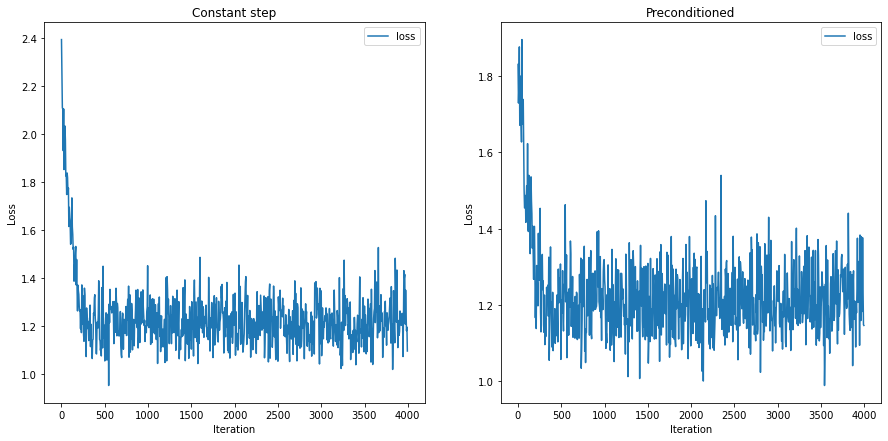

In [10]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(range(0, max_iter, 5), loss_c, label='loss')
plt.title('Constant step')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0, max_iter, 5), loss_pre, label='loss')
plt.title('Preconditioned')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc='best')

#plt.savefig('./figures/convergence_sgd_wine.eps', format='eps')

plt.show()

### Theoretical covariance

In [11]:
# We determine the mean parameter (which is in fact the MAP)
theta_mean_c = theta_sgd_c[cv_it:].mean(axis=0).detach().clone().requires_grad_()
theta_mean_pre = theta_sgd_pre[cv_it:].mean(axis=0).detach().clone().requires_grad_()

# Lets now find the hessian of the loss (remember the quadratic assumption on the loss)
loss = lambda θ : _loss_tot(θ, X_tensor, y_tensor)

hes_c = hessian(loss, theta_mean_c).numpy()
hes_pre = hessian(loss, theta_mean_pre).numpy()

# Theoretical resolution of the lyapunov equation
Σ_c = lyapunov(hes_pre, B, np.eye(len(B)), lr)
Σ_pre = lyapunov(hes_pre, B, precond.numpy(), 1)

### Let's now plot the the results on only two axes

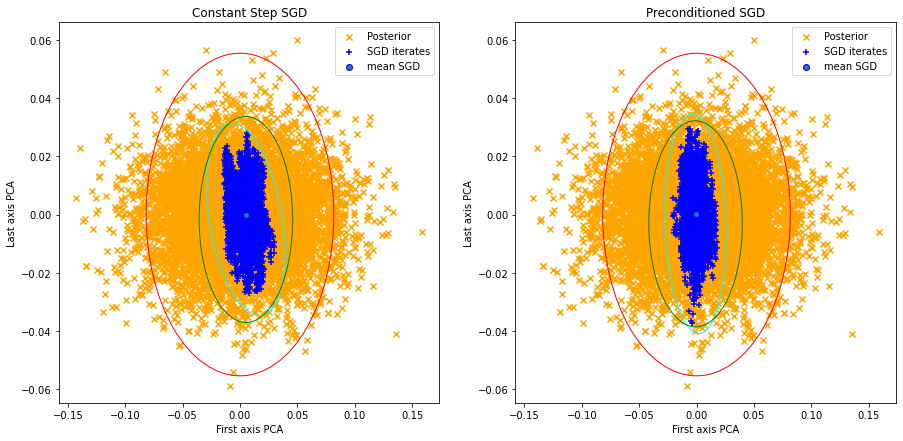

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))

axs[0].scatter(theta_pca[:, 0], theta_pca[:, -1], marker='x', label='Posterior', c='orange')
axs[0].scatter(theta_pca_sgd_c[:, 0], theta_pca_sgd_c[:, -1], marker='+', label='SGD iterates', c='blue')
axs[0].scatter(theta_pca_sgd_c[:, 0].mean(), theta_pca_sgd_c[:, -1].mean(), facecolor=None, edgecolor='blue', label='mean SGD')
confidence_ellipse(theta_pca[:, 0], theta_pca[:, 1], axs[0], n_std=2, edgecolor='red')
confidence_ellipse(theta_pca_sgd_c[:, 0], theta_pca_sgd_c[:, 1], axs[0], n_std=4, edgecolor='cyan')
confidence_ellipse(theta_pca_sgd_c[:, 0], theta_pca_sgd_c[:, 1], axs[0], n_std=2, cov=Σ_c, edgecolor='green')
axs[0].set_xlabel('First axis PCA')
axs[0].set_ylabel('Last axis PCA')
axs[0].legend(loc='best')
axs[0].set_title('Constant Step SGD')

axs[1].scatter(theta_pca[:, 0], theta_pca[:, -1], marker='x', label='Posterior', c='orange')
axs[1].scatter(theta_pca_sgd_pre[:, 0], theta_pca_sgd_pre[:, -1], marker='+', label='SGD iterates', c='blue')
axs[1].scatter(theta_pca_sgd_pre[:, 0].mean(), theta_pca_sgd_pre[:, -1].mean(), facecolor=None, edgecolor='blue', label='mean SGD')
confidence_ellipse(theta_pca[:, 0], theta_pca[:, 1], axs[1], n_std=2, edgecolor='red')
confidence_ellipse(theta_pca_sgd_pre[:, 0], theta_pca_sgd_pre[:, 1], axs[1], n_std=4, edgecolor='cyan')
confidence_ellipse(theta_pca_sgd_pre[:, 0], theta_pca_sgd_pre[:, 1], axs[1], n_std=2, cov=Σ_pre, edgecolor='green')

axs[1].set_xlabel('First axis PCA')
axs[1].set_ylabel('Last axis PCA')
axs[1].legend(loc='best')
axs[1].set_title('Preconditioned SGD')

#plt.savefig('./figures/wine_sgd.eps', format='eps')
plt.show()

### Plot of the covariances for all variables

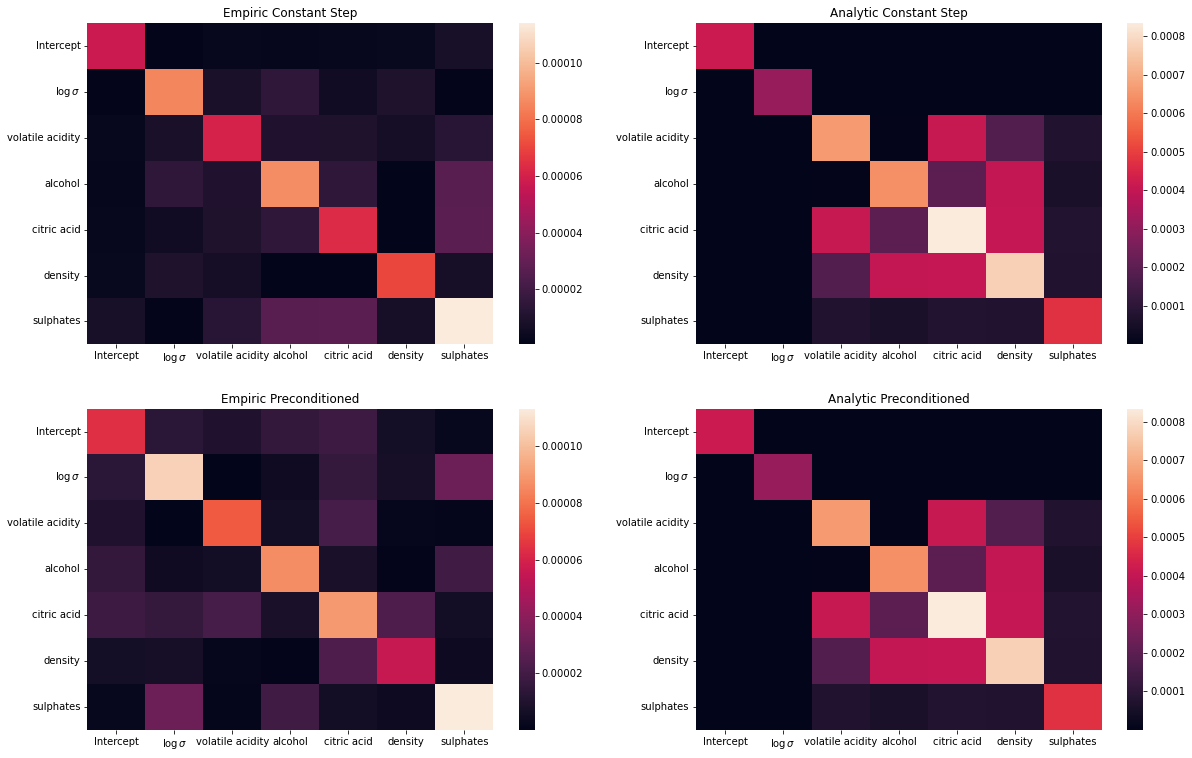

In [13]:
plt.figure(figsize=(20,13))

# Don't forget to compute empirical covariance after convergence
labels = ['Intercept', r'$\log \sigma$'] + var
plt.subplot(2,2,1)
sns.heatmap(np.abs(np.cov(theta_sgd_c[cv_it:].T)), xticklabels=labels, yticklabels=labels)
plt.title('Empiric Constant Step')

plt.subplot(2,2,2)
sns.heatmap(np.abs(Σ_c), xticklabels=labels, yticklabels=labels)
plt.title('Analytic Constant Step')

plt.subplot(2,2,3)
sns.heatmap(np.abs(np.cov(theta_sgd_pre[cv_it:].T)), xticklabels=labels, yticklabels=labels)
plt.title('Empiric Preconditioned')

plt.subplot(2,2,4)
sns.heatmap(np.abs(Σ_pre), xticklabels=labels, yticklabels=labels)
plt.title('Analytic Preconditioned')

#plt.savefig('./figures/covariance_sgd_wine.eps', format='eps')

plt.show()